<a href="https://colab.research.google.com/github/yaj0212/Introductory-Machine-Learning/blob/main/assignments/assn2/assn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introductory Machine Learning: Assignment 2

**Deadline:**

Assignment 2 is due Thursday, February 19 at 11:59pm. Late work will not be accepted as per the course policies (see the syllabus on [Canvas](https://canvas.yale.edu)).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas.  You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission:**

Submit your assignment as a .pdf on Gradescope. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. **Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to find your complete solution to each problem.**

To produce the .pdf, please convert to html and then print to pdf. (You may want to use your pdf print menu to scale the pages to be sure that cells are not truncated.) To convert to html, you can use this [converter notebook](https://colab.research.google.com/github/YData123/sds265-sp26/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb).


**Topics**
1. Logistic regression
2. Regularization
3. Stochastic gradient descent
4. Trees
5. Bias-variance tradeoff

## Problem 1: Penguins: An ice example (20 points)

Can you tell one penguin species from another? Let's put what we've learned about logistic regression to (a very cute) test!

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/penguins_ds_species.png" width="500" align="center" style="margin:10px 30px 10px 0px">

We first need to learn a little about the anatomy of our flightless feathered friends. The *culmen* is the upper ridge of a bird’s bill.

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/penguins_ds_culmen.png" width="500" align="center" style="margin:10px 30px 10px 0px">

In our dataset, the culmen length and depth are called `bill_length_mm` and `bill_depth_mm`.

*Data were collected and made available by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) and the [Palmer Station, Antarctica LTER](https://pallter.marine.rutgers.edu/), a member of the [Long Term Ecological Research Network](https://lternet.edu/). Artwork by @allison_horst.


In [1]:
# run this cell to import needed packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# just run this cell to read in the data, and drop a couple variables

df = pd.read_csv('https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/penguins.csv')
df = df.drop(columns=['index','year','island'])
df = df.dropna(axis=0)
df



,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,39.1,18.7,181.0,3750.0,male
1,Adelie,39.5,17.4,186.0,3800.0,female
2,Adelie,40.3,18.0,195.0,3250.0,female
4,Adelie,36.7,19.3,193.0,3450.0,female
5,Adelie,39.3,20.6,190.0,3650.0,male
...,...,...,...,...,...,...
339,Chinstrap,55.8,19.8,207.0,4000.0,male
340,Chinstrap,43.5,18.1,202.0,3400.0,female
341,Chinstrap,49.6,18.2,193.0,3775.0,male
342,Chinstrap,50.8,19.0,210.0,4100.0,male


In [3]:
# Next we'll make the sex variable binary, and separate out
# species as the label to predict

species = list(set(df['species']))
df['class'] = LabelEncoder().fit_transform(df['species'])
sex = [int(list(df['sex'])[j]=='male') for j in range(len(df))]
df['sex'] = sex
df = df.drop(columns=['species'])
df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,class
0,39.1,18.7,181.0,3750.0,1,0
1,39.5,17.4,186.0,3800.0,0,0
2,40.3,18.0,195.0,3250.0,0,0
4,36.7,19.3,193.0,3450.0,0,0
5,39.3,20.6,190.0,3650.0,1,0
...,...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,1,1
340,43.5,18.1,202.0,3400.0,0,1
341,49.6,18.2,193.0,3775.0,1,1
342,50.8,19.0,210.0,4100.0,1,1


### 1.1 Plotting the data

The following cell shows a scatter plot of all pairs of variables. We showed this type of plot in class for the California housing data.
Describe several entries in this plot, and what it tells you about the
the relationship between the pairs of covariates. Do the relationships make intuitive sense? Why or why not? Do the data appear to have any obvious outliers or unusual patterns? Why or why not?


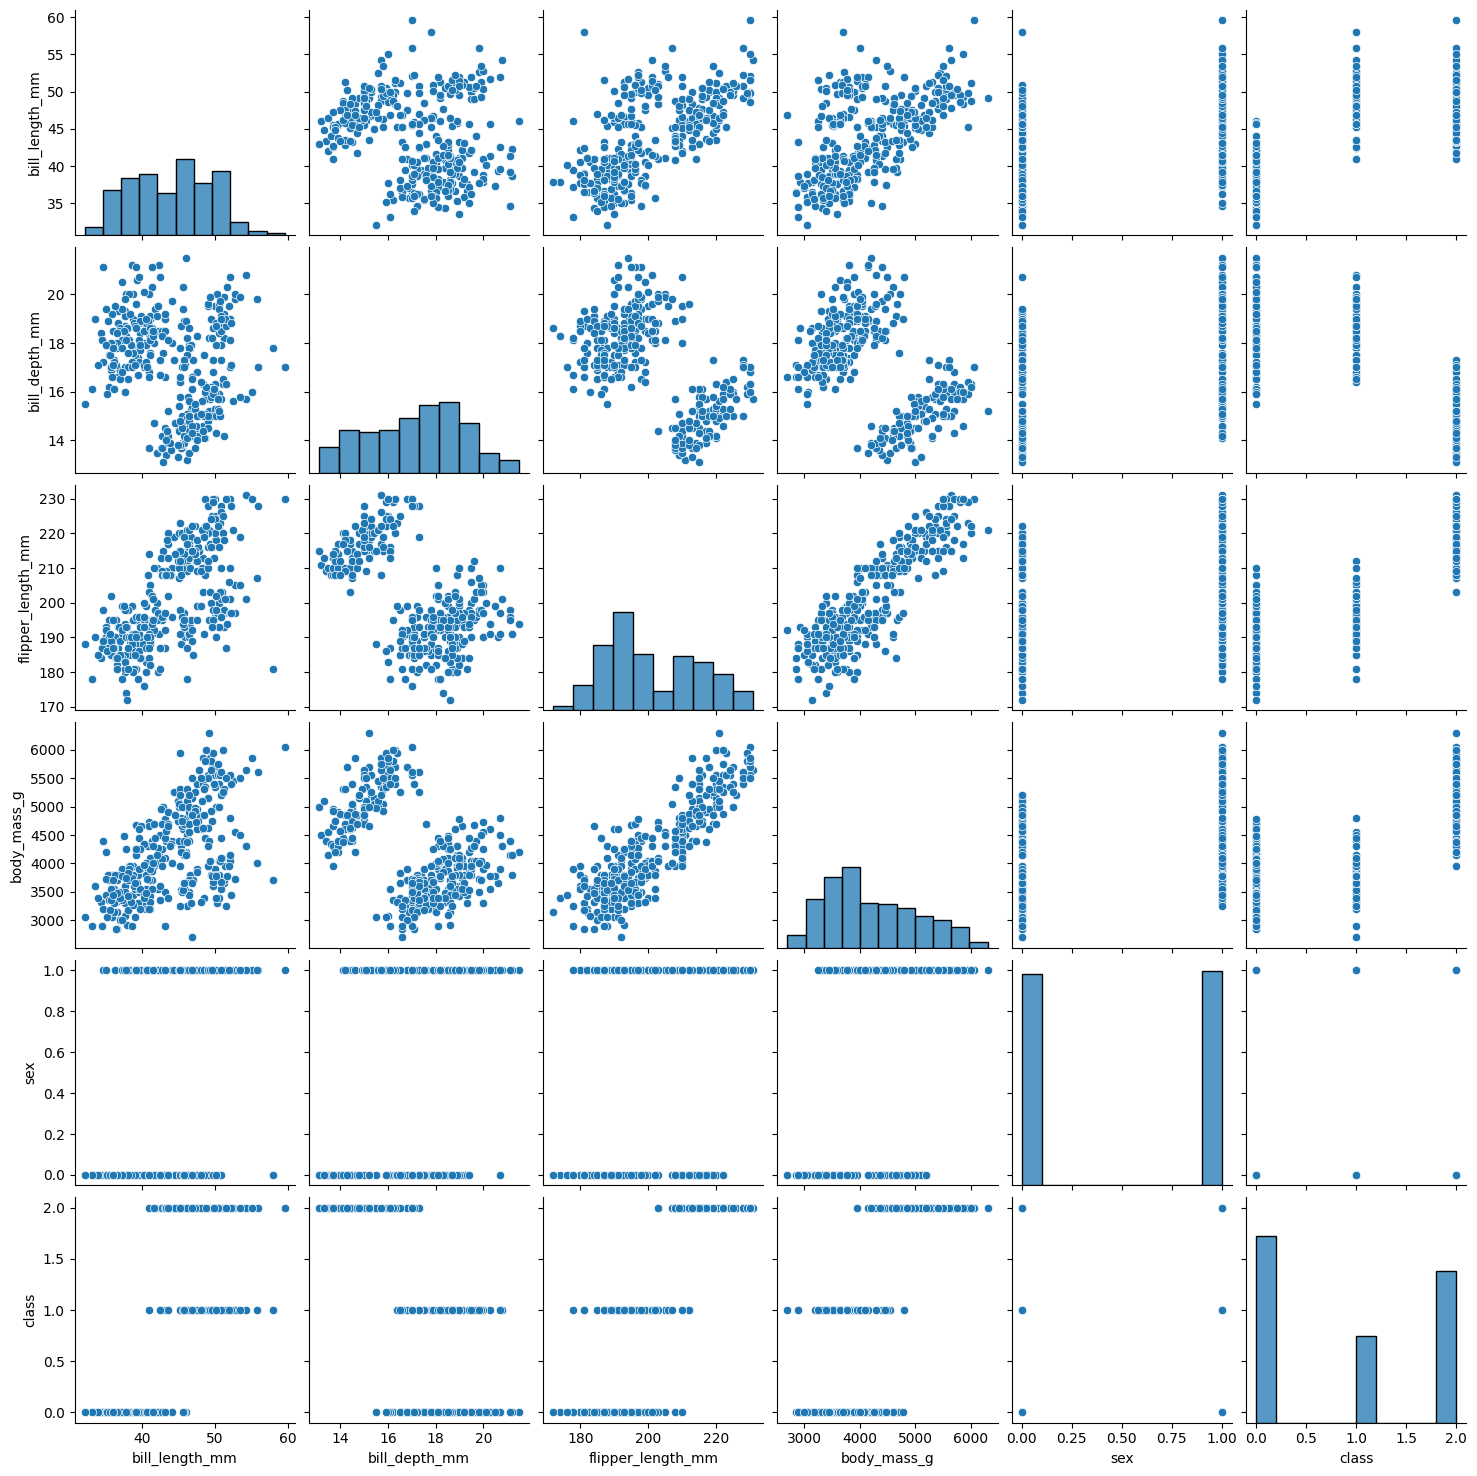

In [4]:
_ = sns.pairplot(df)

Answer: The pairplot shows strong positive relationships among the continuous body-size variables, particularly between flipper length and body mass, and between bill length and flipper length, indicating that larger penguins tend to weigh more and have longer flippers and bills. The plot of bill length versus bill depth reveals distinct clusters rather than a single linear trend, suggesting clear species-level differences in bill morphology. When examining sex, males generally appear slightly larger in body mass and flipper length, which aligns with expected sexual dimorphism.

The encoded class  variable shows well-separated vertical bands, indicating that morphological measurements differ substantially across species and would likely be strong predictors in a classification task. There do not appear to be obvious extreme outliers. Overall, the relationships are coherent, biologically interpretable, and consistent with expectations for morphological traits.

In [5]:
def plot_features(df, feature1_name, feature2_name):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    colors = ['orange', 'pink', 'lightgreen']
    species = ['Adelie', 'Chinstrap', 'Gentoo']

    for c in range(3):
        mask = (df['class']==c)
        plt.scatter(df[feature1_name][mask],
                    df[feature2_name][mask],
                    color=colors[c], label=species[c])

    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.legend(loc='upper left')
    plt.show()



### 1.1 Plotting the data (continued)

Next, using the `plot_features` function above,
give additional plots of pairs of features, shown together with
the class labels. An example of such a plot is shown below:

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/feature_plot.jpg" width="500" align="center" style="margin:10px 30px 10px 0px">

For each plot, discuss why the pair of features may or not be helpful in discriminating between the three species of penguins.

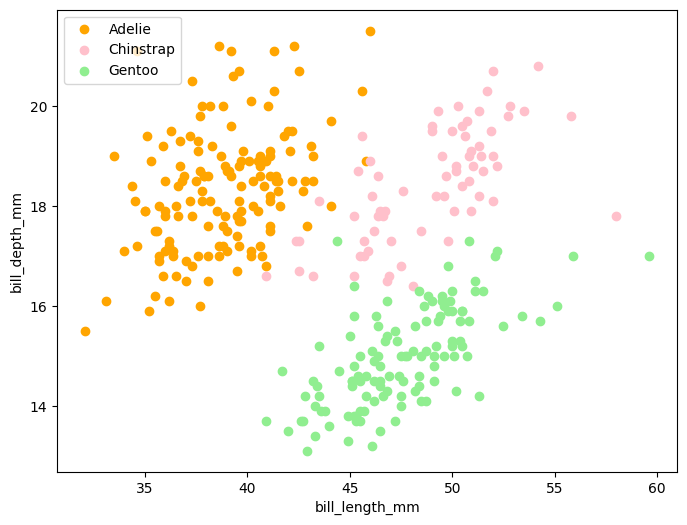

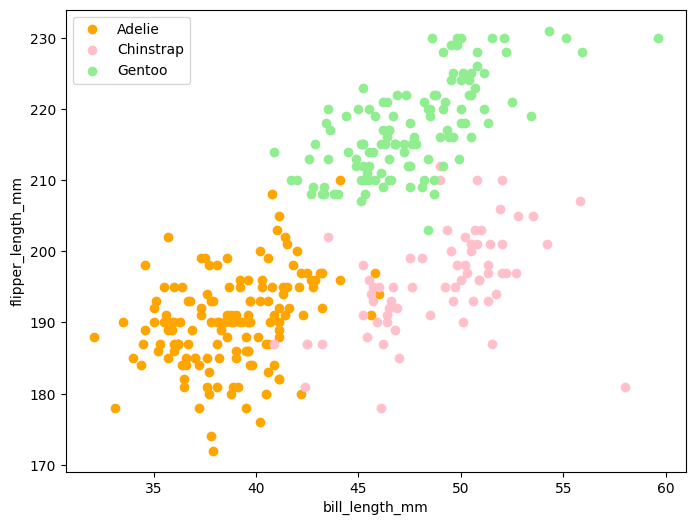

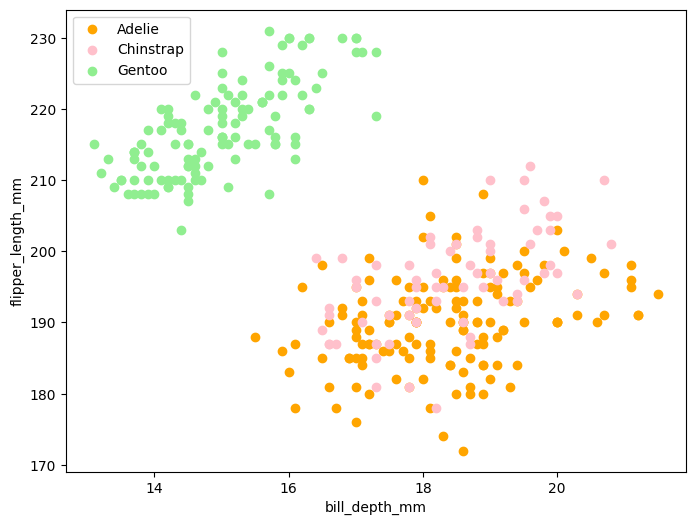

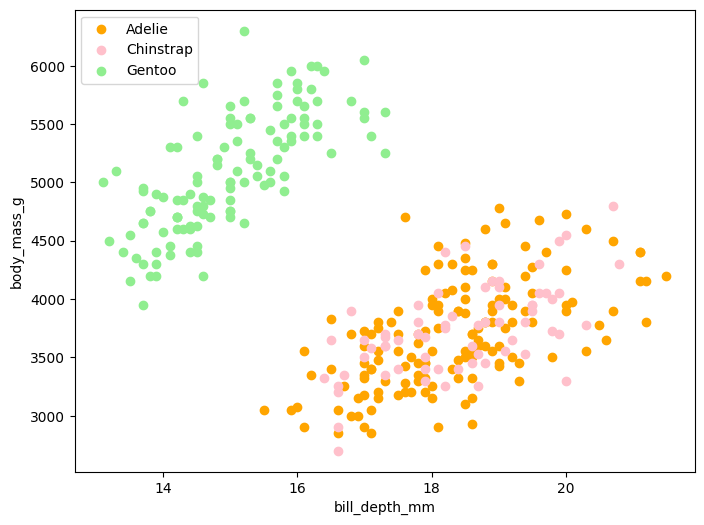

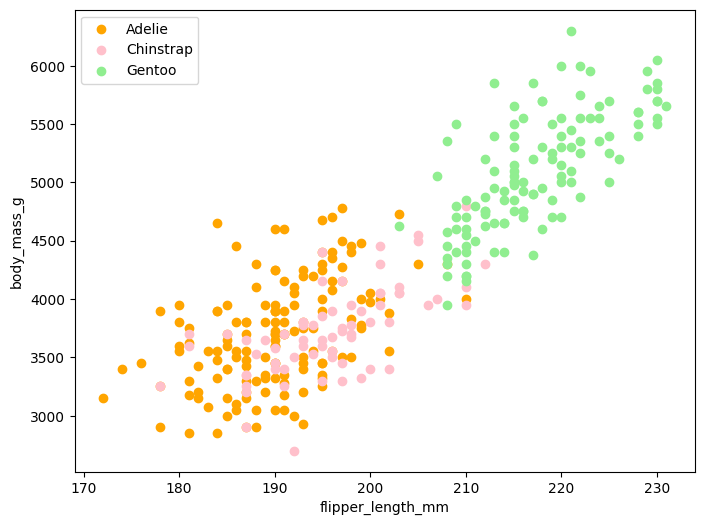

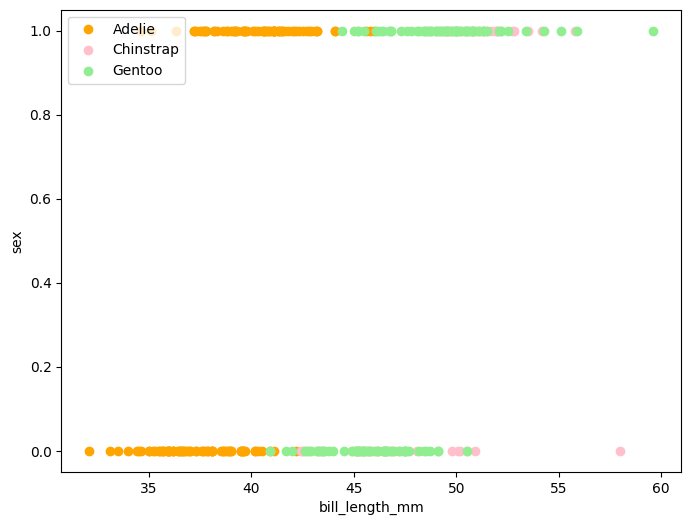

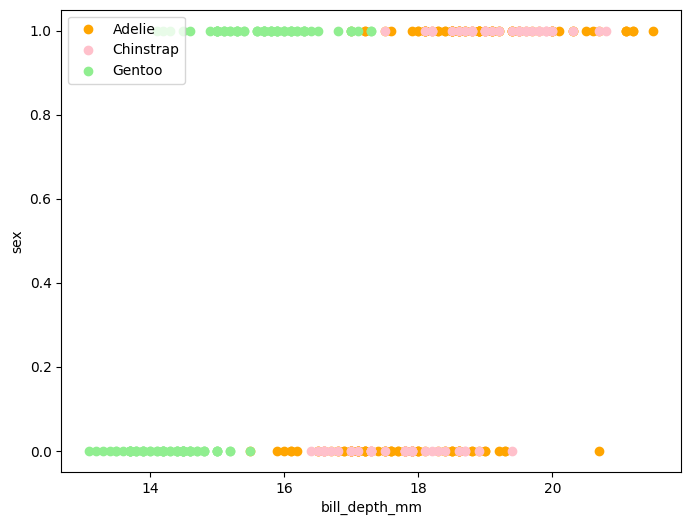

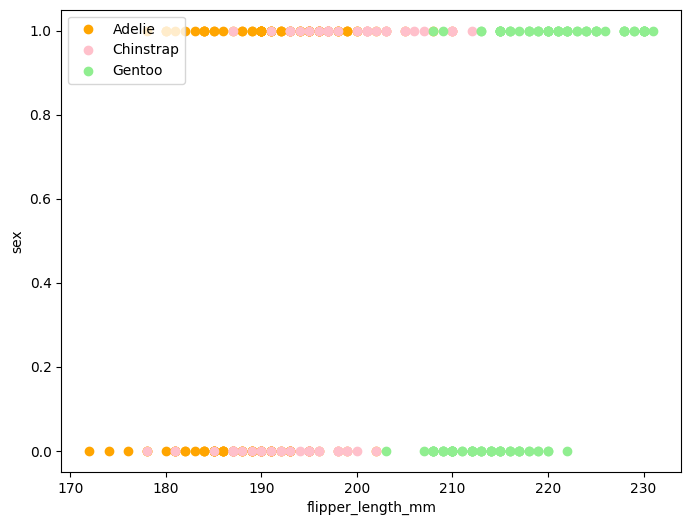

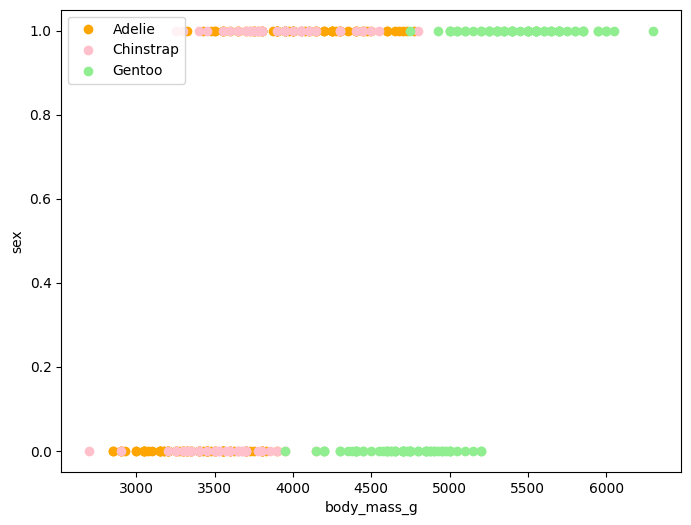

In [6]:
# your code and markdown here

plot_features(df, 'bill_length_mm', 'bill_depth_mm')
plot_features(df, 'bill_length_mm', 'flipper_length_mm')
plot_features(df, 'bill_depth_mm', 'flipper_length_mm')
plot_features(df, 'bill_depth_mm', 'body_mass_g')
plot_features(df, 'flipper_length_mm', 'body_mass_g')
plot_features(df, 'bill_length_mm', 'sex')
plot_features(df, 'bill_depth_mm', 'sex')
plot_features(df, 'flipper_length_mm', 'sex')
plot_features(df, 'body_mass_g', 'sex')

1. Bill Length vs Body Mass
This pair separates Gentoo clearly in the upper-right (longer bills, heavier mass) and Adelie in the lower-left, with some overlap between Adelie and Chinstrap. It is fairly helpful for discrimination, mainly due to overall size differences.

2. Bill Length vs Bill Depth
It captures bill shape differences: Adelie have shorter, deeper bills, Gentoo longer, shallower bills, and Chinstrap are distinct as well. The clusters are well separated, making this pair strong for classification.

3. Bill Length vs Flipper Length
Gentoo are clearly separated with longer flippers, Adelie cluster in the lower-left, and Chinstrap fall in between. This pair is useful because it reflects overall body size differences.

4. Bill Depth vs Flipper Length
Gentoo cluster clearly at longer flippers and shallower bill depth, separating well from the other two species. Adelie and Chinstrap overlap somewhat, so this pair mainly helps distinguish Gentoo.

5. Bill Depth vs Body Mass
Gentoo again separate due to higher body mass and smaller bill depth, while Adelie and Chinstrap overlap more. This pair moderately discriminates Gentoo but is weaker for separating Adelie and Chinstrap.

6. Flipper Length vs Body Mass
This pair shows strong positive correlation and very clear separation of Gentoo as the largest species. It is highly effective for distinguishing Gentoo, though Adelie and Chinstrap still overlap somewhat.

7. Bill Length vs Sex
Males tend to have longer bills across all species, with clear separation between sexes. Adelie penguins cluster at shorter bill lengths while Gentoo and Chinstrap extend higher.

8. Bill Depth vs Sex
Gentoo penguins (green) cluster at lower bill depths and separate well from Adelie and Chinstrap, which overlap substantially with each other at higher depths.

9. Flipper Length vs Sex
Strong sex separation with males having longer flippers. Gentoo clearly separates from the other species with longer flippers, while Adelie and Chinstrap overlap.

10. Body Mass vs Sex
The most pronounced sex difference—males are consistently heavier across all species. Gentoo are distinctly heavier and well-separated, while Adelie and Chinstrap overlap.

The less informative pairs are bill depth vs body mass and, to a lesser extent, bill depth vs flipper length, because Adelie and Chinstrap show substantial overlap in these plots, making them weaker for separating all three species. These pairs mainly distinguish Gentoo but do not clearly separate Adelie from Chinstrap. Adding sex as a feature improves within-species classification, as males are consistently larger across all measurements, but does not resolve the Adelie-Chinstrap overlap since both species show similar sex-based patterns.

In [7]:
# Just run the following cell, to get inputs X and labels y
y = np.array(df['class'])
X = df.copy()
X = X.drop(columns=['class'])
X

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,1
340,43.5,18.1,202.0,3400.0,0
341,49.6,18.2,193.0,3775.0,1
342,50.8,19.0,210.0,4100.0,1


### 1.2 Standardize the data

Next, standardize the data, so that each column of `X` has
mean zero and standard deviation one. Note that after you have done this transformation, `X` should still be a `pandas.DataFrame`. Then, briefly explain why it is important to standardize the variables in the logistic regression models that you will train below.

In [8]:
# Your code here
X = (X - X.mean()) / X.std()

Answer: Standardizing ensures coefficients are comparable across variables on different scales (some are lengths and some are weights) and improves numerical stability during model optimization.


### 1.3 Fit logistic regressions

As done in the class demo for mushrooms and iris flowers, you will now  construct a series of logistic regression models using an increasing number of training points.

Specifically, we want you to:

* Vary the sample size from 10% of the data to 90% of the data, in increments of 10%
* For each sample size, train a logistic regression model on randomly selected training points, and test on the remaining data
* For each sample size, run 100 trials and average the error rates
* Plot the resulting average error rates as a function of sample percentage of the data

We will use the function sklearn.model_selection.train_test_split in each trial to randomly split the data into training and test sets.

Here we repeat exactly what we did during class using `lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')` to fit a logistic regression model to predict the three species  (*Adelie*, *Chinstrap*, and *Gentoo*).

After filling in your code, simply run this cell to plot a learning curve of error rate as a function of training percentage.


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


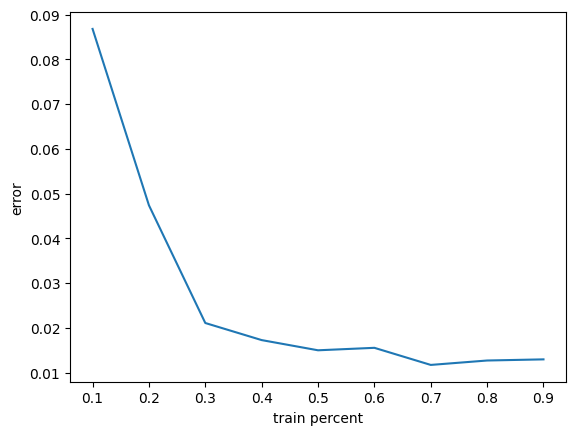

In [9]:
from tqdm import tqdm
lr = LogisticRegression(penalty='l2', C=.1)

lr_error_rate = []
trials = 100
train_percent = np.linspace(.1, .9, 9)

# For each training set percentage, create train/test split accordingly
# and run logistic regression 100 times and calculate the average error rate

"""
function input:
  X: data
  y: label
  ratio: train data percentage
  trails: number of trails to run

function return:
  the average error rate with this train data percentage
"""

def get_err_rate(X, y, ratio, trials):
    # todo:
    # your code starts here
    errors = []
    for trial in range(trials):
      X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio)
      lr.fit(X_train, y_train)
      error = np.mean(lr.predict(X_test) != y_test)
      errors.append(error)
    errors = np.mean(errors)
    return errors
    # your code ends here

# Use get_err_rate to find the error rate for respective split size
for p in tqdm(train_percent):
  lr_error_rate.append(get_err_rate(X, y, p, trials))


plt.plot(train_percent, lr_error_rate)
plt.xlabel('train percent')
plt.ylabel('error')
plt.show()

### 1.4 Choose good feature pairs

Which pair of variables gives the best predictions of the species of penguins? Run some experiments and report back below!

Note that there are ${5 \choose 2} = 10$ ways you can choose a pair of features. You may want to run a loop to automate this. And choose a reasonable `ratio` from the stable region of plot 1.3, such as 0.7 :)




In [10]:
# todo:
# your code starts here
for i in range(X.shape[1]):
  for j in range(i+1, X.shape[1]):
    X_pair = X.iloc[:, [i, j]]
    error = get_err_rate(X_pair, y, 0.7, trials)
    print(f'Prediction error of {X.columns.values[i]} and {X.columns.values[j]}: ', error)

# your code ends here

Prediction error of bill_length_mm and bill_depth_mm:  0.0654
Prediction error of bill_length_mm and flipper_length_mm:  0.048900000000000006
Prediction error of bill_length_mm and body_mass_g:  0.071
Prediction error of bill_length_mm and sex:  0.23470000000000002
Prediction error of bill_depth_mm and flipper_length_mm:  0.19890000000000005
Prediction error of bill_depth_mm and body_mass_g:  0.20370000000000002
Prediction error of bill_depth_mm and sex:  0.22490000000000002
Prediction error of flipper_length_mm and body_mass_g:  0.21030000000000001
Prediction error of flipper_length_mm and sex:  0.21240000000000003
Prediction error of body_mass_g and sex:  0.21849999999999997


Answer: Based on the results, the best pair is bill_length_mm and flipper_length_mm with the lowest error rate of 4.94%.

### 1.5 Visualize the decision boundries

Using the two features you chose as the best, and at least two additional
pairs of features, visualize the decision boundries of the logistic regression models.

Is it what you expected? Where are you observing incorrect predictions? Describe why the decision boundaries make sense, from your understanding of the logistic regression model.

Use the function `plot_decision_boundaries` that we supply below. (You may also modify this function to your liking.) An example plot is shown here:

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/sample_decision_boundaries.jpg" width="400" align="center" style="margin:10px 30px 10px 0px">


In [11]:
def plot_decision_boundaries(X, y, model, error):
    X2 = np.array(X)
    b = model.intercept_
    beta = model.coef_.T
    colors = ['orange', 'pink', 'lightgreen']
    h = 0.015
    x_min, x_max = X2[:, 0].min() - .5, X2[:, 0].max() + .5
    y_min, y_max = X2[:, 1].min() - .5, X2[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], beta) + b
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8,8))
    plt.contourf(xx, yy, Z, levels=[0,.5,1.5,2.5], colors=colors, alpha=0.5)
    for c in range(3):
        mask = (y==c)
        plt.scatter(X2[np.array(mask),0], X2[np.array(mask),1], color=colors[c], label=species[c])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend(loc='upper left')
    plt.title('error rate: %.2f' % error)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])


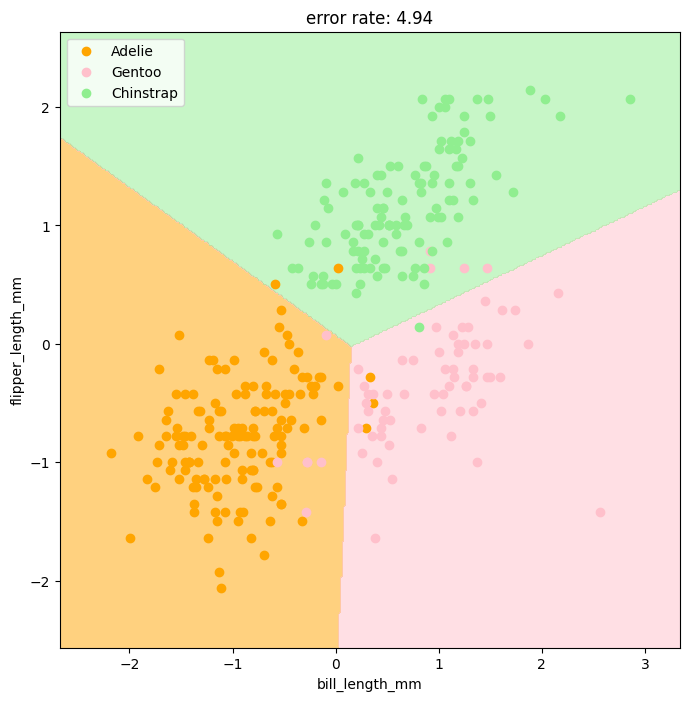

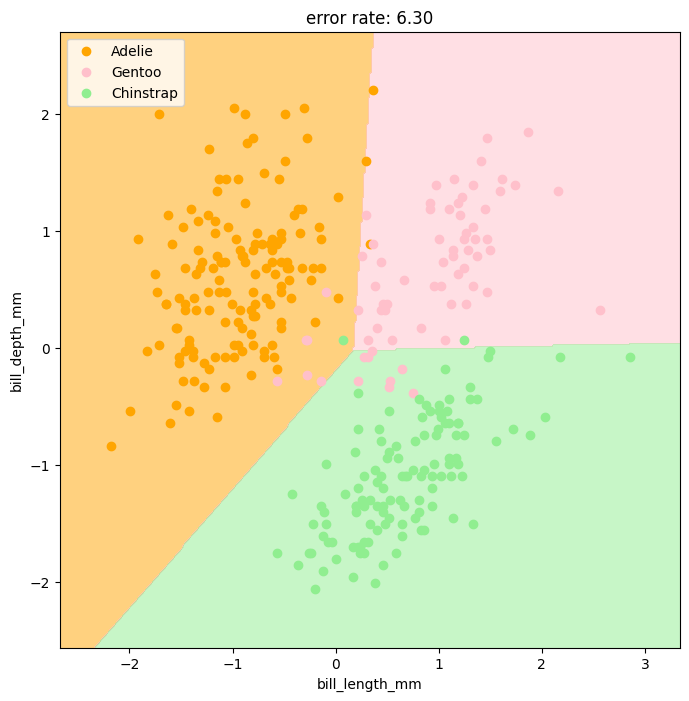

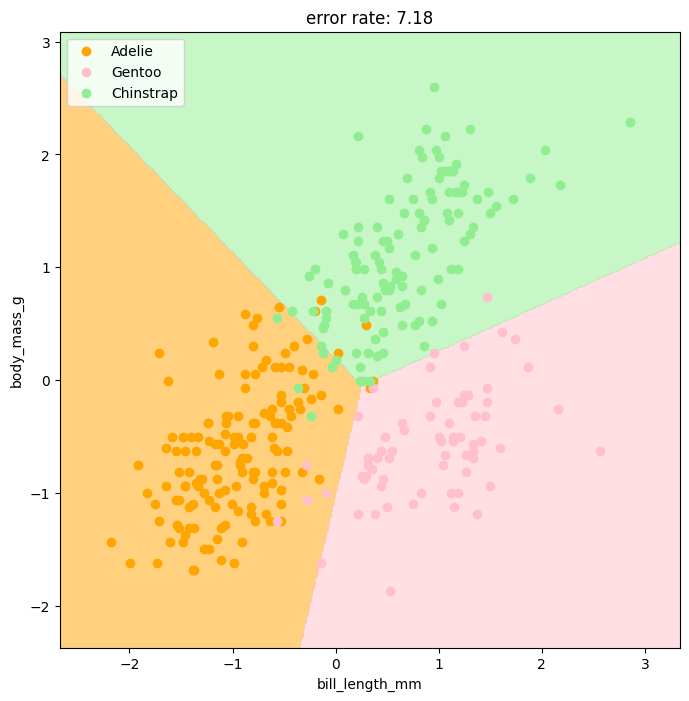

In [12]:
# Your code and markdown here
X_train_pair1, X_test_pair1, y_train_pair1, y_test_pair1 = train_test_split(X[['bill_length_mm', 'flipper_length_mm']], y, train_size=0.7)
model1 = lr.fit(X_train_pair1, y_train_pair1)
error1 = get_err_rate(X[['bill_length_mm', 'flipper_length_mm']], y, 0.7, trials)
plot_decision_boundaries(X[['bill_length_mm', 'flipper_length_mm']], y, model1, error1 * 100)

X_train_pair2, X_test_pair2, y_train_pair2, y_test_pair2 = train_test_split(X[['bill_length_mm', 'bill_depth_mm']], y, train_size=0.7)
model2 = lr.fit(X_train_pair2, y_train_pair2)
error2 = get_err_rate(X[['bill_length_mm', 'bill_depth_mm']], y, 0.7, trials)
plot_decision_boundaries(X[['bill_length_mm', 'bill_depth_mm']], y, model2, error2 * 100)

X_train_pair3, X_test_pair3, y_train_pair3, y_test_pair3 = train_test_split(X[['bill_length_mm', 'body_mass_g']], y, train_size=0.7)
model3 = lr.fit(X_train_pair3, y_train_pair3)
error3 = get_err_rate(X[['bill_length_mm', 'body_mass_g']], y, 0.7, trials)
plot_decision_boundaries(X[['bill_length_mm', 'body_mass_g']], y, model3, error3 * 100)

Answer: The resulting plots match expectations, bill_length_mm vs flipper_length_mm shows the cleanest separation with three distinct clusters. Misclassifications are most evident near the center where both measurements are around 0 (the mean after standardization), this is where all three species converge and the decision boundaries meet.

The boundaries are straight lines meeting at a point because logistic regression is a linear classifier. Each region represents where one class has the highest predicted probability. The model draws the best linear separation it can, but where species clusters overlap near the center, a straight line cannot perfectly separate them.

### 1.6 (Optional) Use different regularization levels (2 points EC)

Now that you have a working logistic regression algorithm, explore how to set the regularization level $C=1/\lambda$. Use an appropriate cross-validation procedure to choose the regularization level, and explain your results.

In [13]:
# Your code and markdown here
from sklearn.model_selection import cross_val_score

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
cv_errors = []

for C in C_values:
    lr = LogisticRegression(penalty='l2', C=C, max_iter=1000)
    scores = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
    cv_errors.append(1 - scores.mean())  # error rate
    print(f'C = {C}: error = {1 - scores.mean():.4f}')

# Best C has lowest error
best_C = C_values[np.argmin(cv_errors)]
print(f'Best C: {best_C}')

C = 0.001: error = 0.2042
C = 0.01: error = 0.0839
C = 0.1: error = 0.0120
C = 1: error = 0.0060
C = 10: error = 0.0030
C = 100: error = 0.0060
Best C: 10


Hooray! You are now a penguin master!

## Problem 2: Mini-Batch Gradient Descent (25 points)

Consider a univariate logistic regression where we are trying to predict $Y$, which can take the value $0$ or $1$, from the variable $X$, which takes real values. Recall from lecture that we need to estimate parameters $\beta_{0}$ and $\beta_{1}$ by minimizing the penalized loss function:

$L(\beta_{0}, \beta_{1}) = \frac{1}{n}\sum\limits_{i=1}^{n} \left[ log\left( 1 + e^{\beta_{0} + X_{i}\beta_{1}}\right) - Y_{i}\left(\beta_{0} + X_{i}\beta_{1}\right)\right] + \lambda \beta_{1}^{2}$ .

Note that generally the intercept is not penalized.

In this problem, we will implement mini-batch gradient descent. At each iteration, a random set of $m$ samples from all $n$ samples is used to calculate the loss and gradient, which is the change in the loss with respect to the parameters. We then update the estimates of $\beta_{0}$ and $\beta_{1}$ based on the gradient.

Run the next cell to simulate data using the parameter values of $\beta_{0} = 3$ and $\beta_{1} = -5$.

In [14]:
n = 10000
np.random.seed(265)
x1 = np.random.uniform(-5, 5, size=n)
beta0 = 3
beta1 = -5
p = np.exp(beta0 + x1*beta1)/(1 + np.exp(beta0 + beta1*x1))
y = np.random.binomial(1, p, size=n)
y.shape

(10000,)

Here is a helper function for plotting we'll use later. Just run this cell; don't change it.

In [15]:
def plot_betas_and_loss(beta0_all, beta1_all, loss_all, title=''):
    fig, ax = plt.subplots(1, 3, figsize=(18,5))
    ax[0].plot(np.arange(len(beta0_all)), beta0_all)
    ax[0].hlines(beta0, xmin=0, xmax=len(beta0_all),color = 'r')
    ax[0].set_xlabel("Iteration", fontsize=12)
    ax[0].set_ylabel(r"$\widehat{\beta}_{0}$", fontsize=12)

    ax[1].plot(np.arange(len(beta1_all)), beta1_all)
    ax[1].hlines(beta1, xmin=0, xmax=len(beta1_all),color = 'r')
    ax[1].set_xlabel("Iteration", fontsize=12)
    ax[1].set_ylabel(r"$\widehat{\beta}_{1}$", fontsize=12)
    ax[1].set_title(title)

    ax[2].plot(np.arange(len(loss_all)), loss_all)
    ax[2].set_xlabel("Iteration", fontsize=12)
    ax[2].set_ylabel("Loss", fontsize=12)
    plt.show()

### 2.1 Deriving the updates

Let $L_{t}(\beta_{0}, \beta_{1})$ be the loss at $t$-th iteration.
For given values of $\beta_{0}$ and $\beta_{1}$, the vector $\left( \dfrac{\partial}{\partial \beta_{0}} L_{t}(\beta_{0}, \beta_{1}), \dfrac{\partial}{\partial \beta_{1}} L_{t}(\beta_{0}, \beta_{1}) \right)^{T}$ is called the gradient of $L_{t}(\beta_{0}, \beta_{1})$ and is denoted $\nabla L_{t}(\beta_{0}, \beta_{1})$.

We calculate the derivative of $L_{t}(\beta_{0}, \beta_{1})$ with respect to $\beta_{0}$, treating $\beta_{1}$ as a constant. (i.e. calculate $\dfrac{\partial}{\partial \beta_{0}} L_{t}(\beta_{0}, \beta_{1})$):

$\dfrac{\partial}{\partial \beta_{0}} L(\beta_{0}, \beta_{1}) = \frac{1}{n}\sum\limits_{i=1}^{n} \left(\dfrac{e^{\beta_{0} + X_{i}\beta_{1}}}{1+e^{\beta_{0} + X_{i}\beta_{1}}}- Y_{i}\right)$.



Now calculate the derivative of $L_{t}(\beta_{0}, \beta_{1})$ with respect to $\beta_{1}$, treating $\beta_{0}$ as a constant. (i.e. calculate $\dfrac{\partial}{\partial \beta_{1}} L_{t}(\beta_{0}, \beta_{1})$).

Be sure to show your work by either typing it in here using LaTeX, or by taking a picture of your handwritten solutions and displaying them here in the notebook. (If you choose the latter of these two options, be sure that the display is large enough and legible. Please also upload a photo seperately to Gradescope in case the embedded image failed.)


$\dfrac{\partial}{\partial \beta_{1}} L(\beta_{0}, \beta_{1}) = \frac{1}{n}\sum\limits_{i=1}^{n} \left(\dfrac{e^{\beta_{0} + X_{i}\beta_{1}}}{1+e^{\beta_{0} + X_{i}\beta_{1}}} \cdot {X_i} - Y_{i} \cdot {X_i}\right) + 2\cdot \lambda \cdot \beta_1$.

When we implement mini-batch stochastic gradient descent, we will use these formulas, but
apply them to a mini-batch of $m$ randomly chosen datapoints, rather than to all $n$ datapoints
(in our case $n=10,000$).
Typically $m$ is chosen to be much, much smaller than $n$.




### 2.2 The key ingredients

Complete the function `update` in the following cell which takes values for $\beta_{0}$ and $\beta_{1}$, a list `inds`  containing the indexes of the $m$ selected samples, as well as a step-size $\eta$, and returns updated values for $\beta_{0}$ and $\beta_{1}$ from one step of gradient descent (using all the data and your answer to Part a).

In [16]:
def update(b0, b1, inds, step_size, lamb):

    L_partial0 = np.sum((np.exp(b0 + x1[inds] * b1) / (1 + np.exp(b0 + x1[inds] * b1))) - y[inds])
    L_partial0 = 1 / len(inds) * L_partial0
    # your implementation here, can be more than one line
    L_partial1 = np.sum((np.exp(b0 + x1[inds] * b1) / (1 + np.exp(b0 + x1[inds] * b1))) * x1[inds] - y[inds] * x1[inds])
    # your implementation here, can be more than one line
    L_partial1 = 1 / len(inds) * L_partial1 + 2 * lamb * b1

    b0 -= step_size * L_partial0
    b1 -= step_size * L_partial1
    return (b0, b1)

Now complete the function in the next cell called `loss` which takes values for $\beta_{0}$ and $\beta_{1}$,
together with a subset of indices and regularization parameter, and returns the value of the loss function evaluated at those data points.

In [17]:
def loss(b0, b1, inds, lamb):

    output = np.sum(np.log(np.exp(b0 + x1[inds] * b1) / (1 + np.exp(b0 + x1[inds] * b1))) - y[inds] * (b0 + x1[inds] * b1))
    output = (1 / len(inds)) * output + lamb * b1**2
    # your implementation here, can be more than one line

    return output

### 2.3 Putting it all together

Now complete the implementation of `minibatch_grad_descent` which puts all of these pieces together

In [18]:
def minibatch_grad_descent(b0=0, b1=0, batch_size=100, step_size=10, lamb=0, iterations=1000):
    beta0_hat = b0
    beta1_hat = b1
    beta0_all = []
    beta1_all = []
    loss_all = []

    for iter in range(iterations):
        inds = np.random.choice(n, size = batch_size)  # your implementation: sample batch_size indices
        batch_loss = loss(beta0_hat, beta1_hat, inds, lamb) # your implementation: call loss()
        beta0_hat, beta1_hat = update(beta0_hat, beta1_hat, inds, step_size, lamb) # your implementation: call update()

        beta0_all.append(beta0_hat)
        beta1_all.append(beta1_hat)
        loss_all.append(batch_loss)

    return (beta0_hat, beta1_hat, beta0_all, beta1_all, loss_all)

Now, test your implementation by running the following cell, which will call the function
with the default parameters, and then plot the beta parameters and loss during the course
of stochastic gradient descent. We will check your plot as a first check that you have a correct implementation! You should expect the first plot looks like the following:

<img src="https://github.com/YData123/sds265-sp26/raw/main/assignments/assn2/mini_batch_gd.png" width="400" align="center" style="margin:10px 30px 10px 0px">

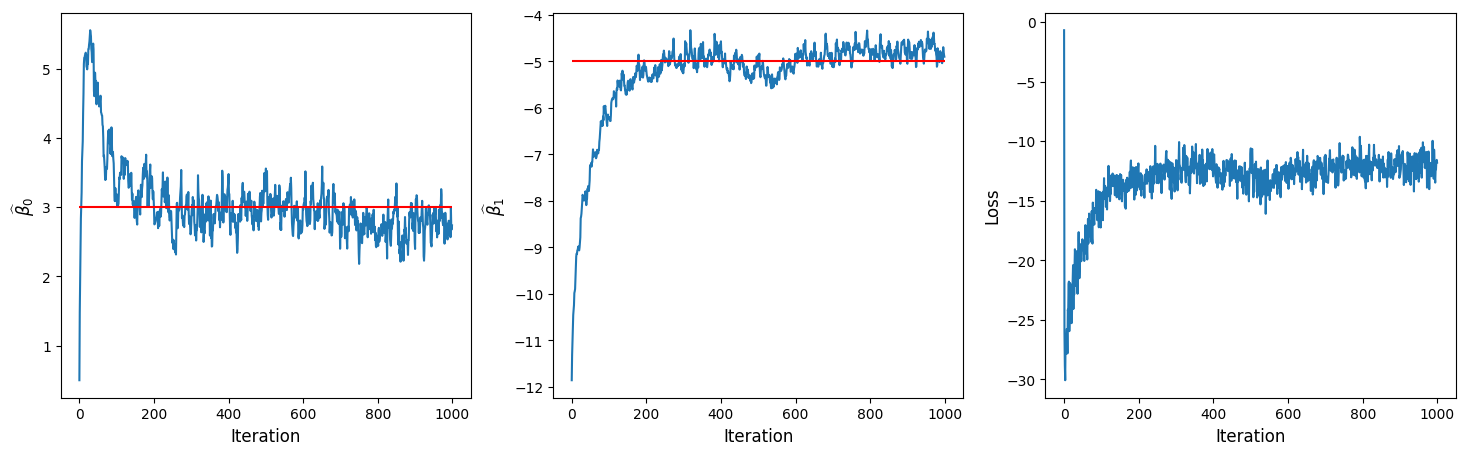

In [19]:
# Run this cell, don't change it!

beta0_hat, beta1_hat, beta0_all, beta1_all, loss_all = minibatch_grad_descent()
plot_betas_and_loss(beta0_all, beta1_all, loss_all)


### 2.4 Assessing uncertainty

We now use the code above that implements mini-batch gradient descent and
run it several (30) times. We then display the mean and standard deviation of
the estimates.


In [20]:
# run this cell, don't change it

from tqdm import tqdm

beta0_hat_all_0 = []
beta1_hat_all_0 = []
for rep in tqdm(range(30)):
    beta0_hat, beta1_hat, _, _, _ = minibatch_grad_descent()
    beta0_hat_all_0.append(beta0_hat)
    beta1_hat_all_0.append(beta1_hat)

print('The mean of the estimated beta0 is %.2f' % np.mean(beta0_hat_all_0))
print('The standard deviation of the estimated beta0 is %.3f' % np.std(beta0_hat_all_0))
print('The mean of the estimated beta1 is %.2f' % np.mean(beta1_hat_all_0))
print('The standard deviation of the estimated beta1 is %.3f' % np.std(beta1_hat_all_0))

100%|██████████| 30/30 [00:04<00:00,  7.06it/s]

The mean of the estimated beta0 is 2.94
The standard deviation of the estimated beta0 is 0.225
The mean of the estimated beta1 is -4.82
The standard deviation of the estimated beta1 is 0.166


Comment on these results:

1. Describe what causes the variation in the estimates.

1. How would you construct approximate 95% confidence intervals for the estimates?
1. Do the true parameters fall in those confidence intervals?

Answer:
1. From random mini-batch sampling, each of the 30 replications runs 1000 iterations, and each iteration samples a different random set of 100 points of a total of 10000 points.

2. Assuming the result follows a normal distribution, 95% roughly corresponde to mean ± 2 $\times$ standard deviation, so we can subsitute the mean and standard deviation of $\beta_1$ and $\beta_0$ in and check if their sampling means fall within that range.

3. For $\beta_0$, its 95% range is 2.87 ± 2 $\times$ 0.175, which is (2.52, 3.22). For $\beta_1$, its 95% range is -4.83 ± 2 $\times$ 0.232, which is (-5.294, -4.366). Since $\beta0 = 3$ and $\beta_1 = -5$, so yes, both true parameters fall within the 95% confidence intervals.

### 2.5 Comparing regularization levels

Repeat 2.3 with different $\lambda$ (the regularization level), e.g. $\lambda=0$, $\lambda=.001$, and $\lambda=.005$. Use (0,0) as the initial estimates of $\beta_{0}$ and $\beta_{1}$. Plot $\beta_{0}$, $\beta_{1}$, and $L(\beta_{0}, \beta_{1})$ vs. iteration number. How do the plots change as you change $\lambda$? Are the changes consistent with your expectation? Why or why not?

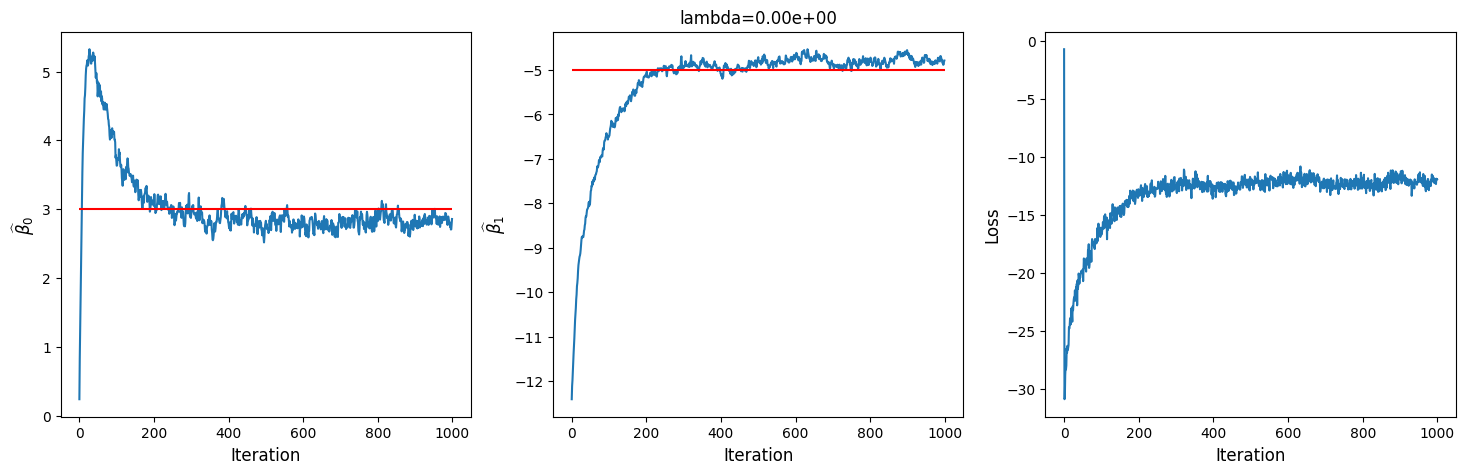

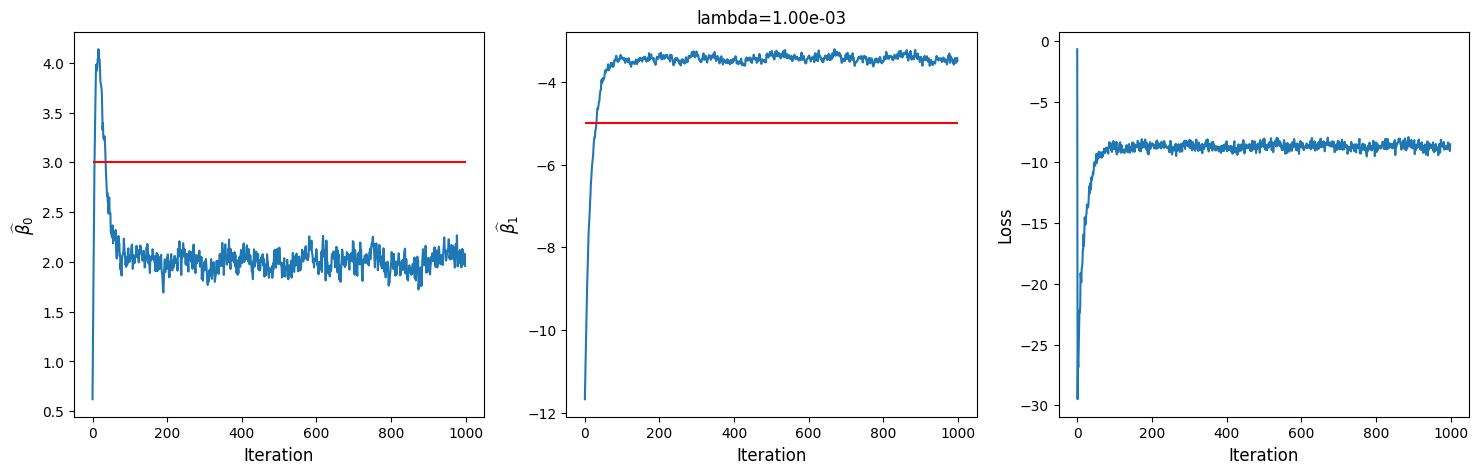

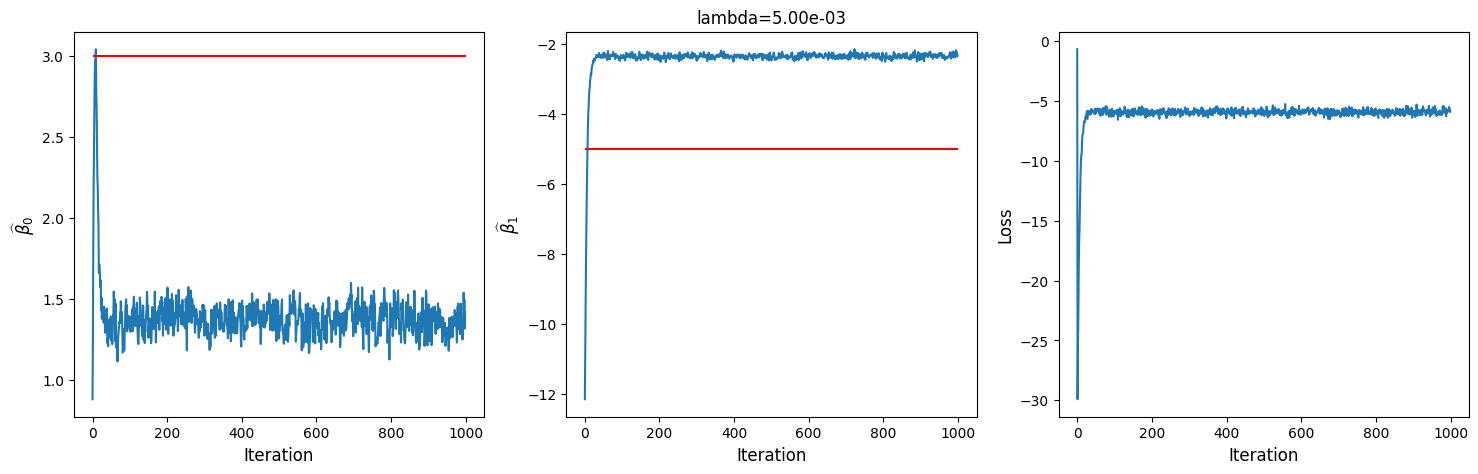

In [21]:
# run this cell, don't change it

for lamb in [0, .001, .005]:
    _, _, beta0_all, beta1_all, loss_all = minibatch_grad_descent(batch_size=500, lamb=lamb)
    plot_betas_and_loss(beta0_all, beta1_all, loss_all, title = 'lambda=%.2e' % lamb)

Comment on these results:

1. Describe what causes the differences in the plots across the three regularization levels.
1. Does one of the three runs give a better estimate than the others? Why or why not?


Answer:
1. The regularization term ($\lambda \beta_1^2$) penalizes large values of $\beta_1$. As $\lambda$ increases:

* The penalty pulls β₁ toward zero more strongly, causing estimates to deviate from true values ($\beta_0$=3,$\beta_1$=-5)
* A larger λ constrains the optimization path, there are less oscillation and trajectories are more smooth.
* The regularization term is added to the loss function, so final loss values are higher

2. With $\lambda$ = 0, we get low bias (estimates hit true values) but high variance (noisy oscillations). With $\lambda$ = 0.005, we get high bias (estimates shrink away from true values) but low variance (stable, smooth paths).
For this simulation, $\lambda$ = 0 gives the best estimates because we know the true parameters and have n = 10000 samples.

### 2.6 Batch size and stochastic gradient descent

Repeat 2.3 with different batch sizes, 1,10,100,1000. How do the plots change as we change batch size? Are the changes consistent with your expectation? Why or why not? Do you think we should use larger batch sizes or smaller ones? How do you reconcile the results with the prevalent use of mini-batch gradient descent rather than SGD and batch gradient descent?

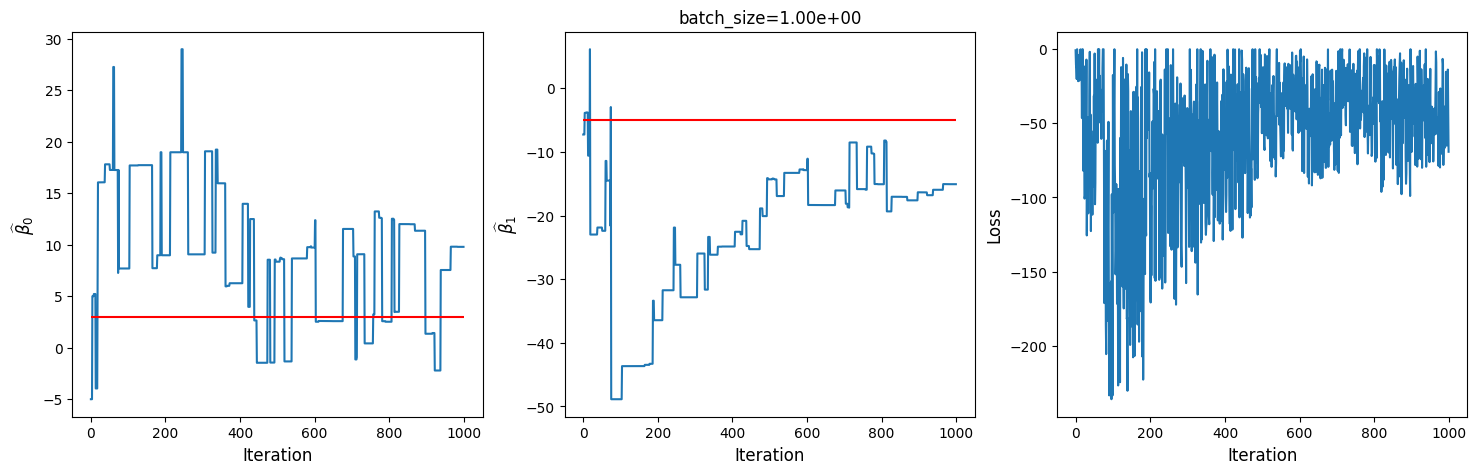

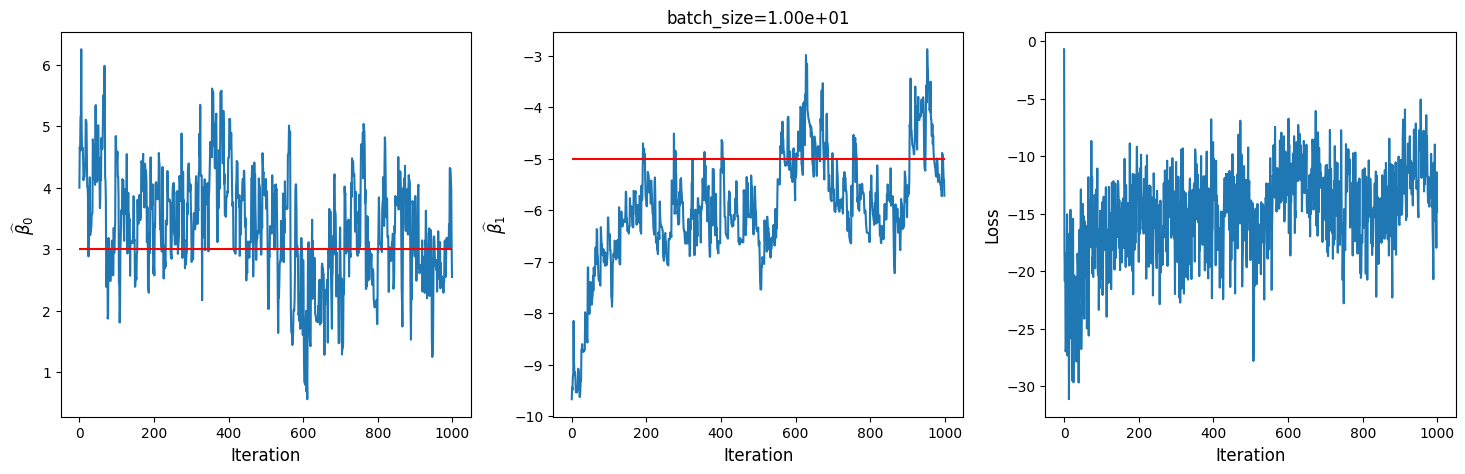

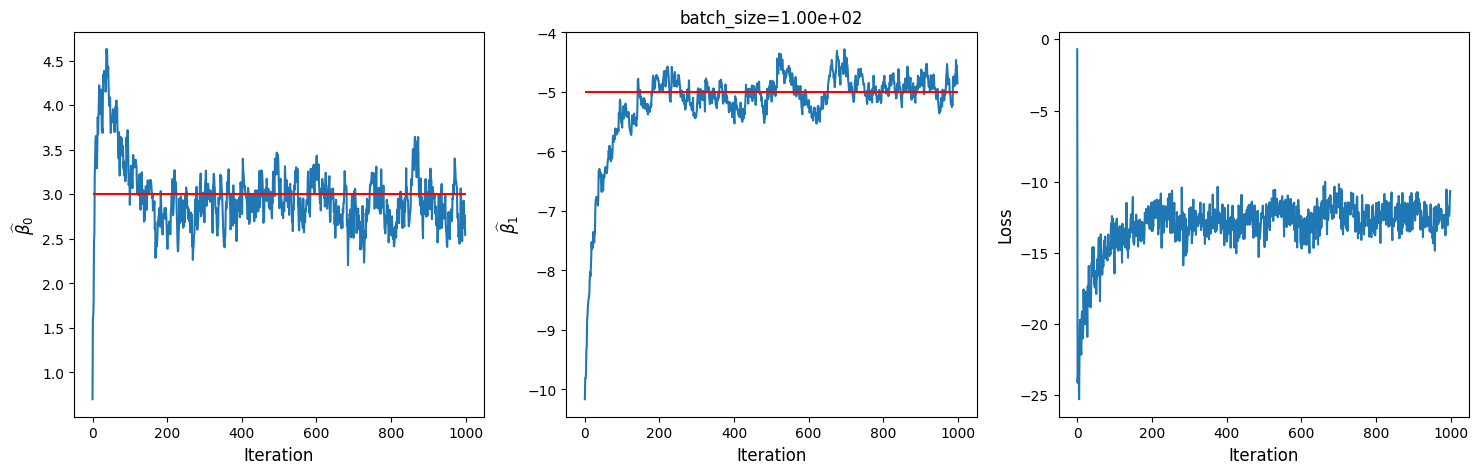

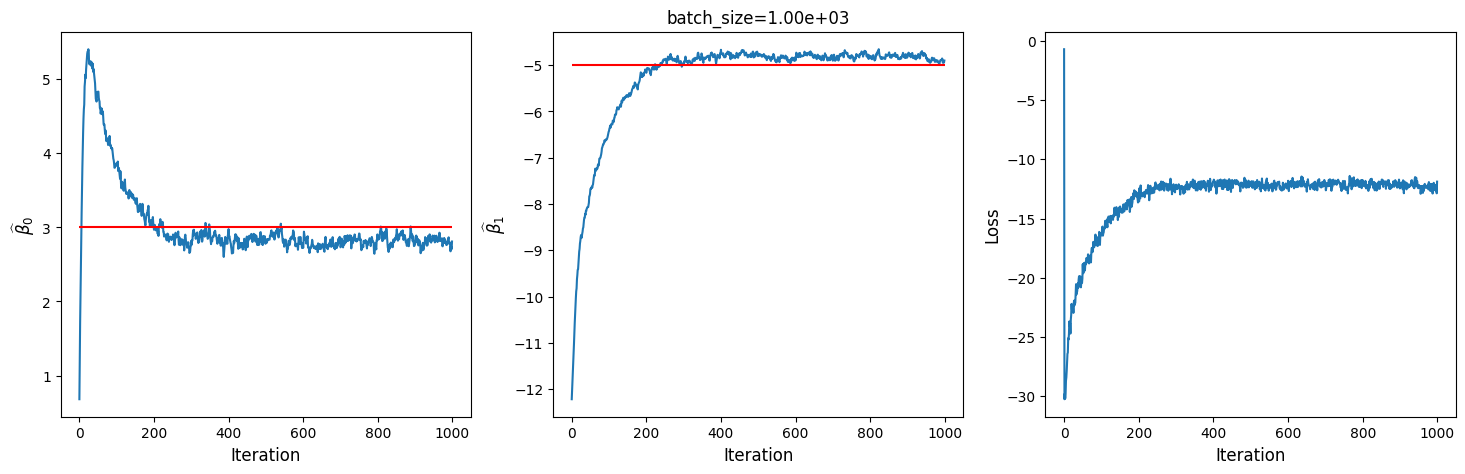

In [22]:
# run this cell, don't change it

for batch_size in [1, 10, 100, 1000]:
    iterations = int(10000/batch_size)
    _, _, beta0_all, beta1_all, loss_all = minibatch_grad_descent(batch_size=batch_size, lamb=0,iterations=1000)
    plot_betas_and_loss(beta0_all, beta1_all, loss_all, title = 'batch_size=%.2e' % batch_size)

Comment on these results:

1. Describe what causes the differences in the plots across the three batch sizes.
2. Does one of the three runs give a better estimate than the others? Why or why not?

Answer:
1. The batch size determines how many samples are used to estimate the gradient at each iteration.


* With batch size = 1 (true SGD), each gradient is computed from a single data point, making it extremely noisy. The estimates swing wildly ($\beta_0$ ranges from -5 to 27, $\beta_1$ ranges from -35 to -10) and never stabilize near the true values. The loss fluctuates dramatically.


* With batch size = 10, the gradient estimate is still quite noisy, but less extreme than batch size 1. The estimates oscillate around the true values but with high variance.


* With batch size = 100, the gradient estimates become more stable. The parameters converge to the true values ($\beta_0 \approx$ 3, $\beta_1 \approx$ -5) with moderate oscillation after convergence.


* With batch size = 1000, the gradient estimates are very stable because each batch represents 10% of the data. The trajectories are smooth, convergence is clear, and oscillation is minimal.

2. Batch size 100 gives the best tradeoff, it converges to the true values with acceptable noise, while being 10 times computationally cheaper than batch 1000.

## Problem 3. Bias and Variance and Trees, Oh My! (20 points)


In this problem you will explore the bias-variance tradeoff for decision trees using a simple toy regression problem. We start by importing a few packages.


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline

The following cell defines and plots the data for this regression problem. The true regression function is `f`; the response `y` is `f` plus noise. The true function is -1 above the line `x1==x2` and 1 below the line. Just run this cell; do not modify it.

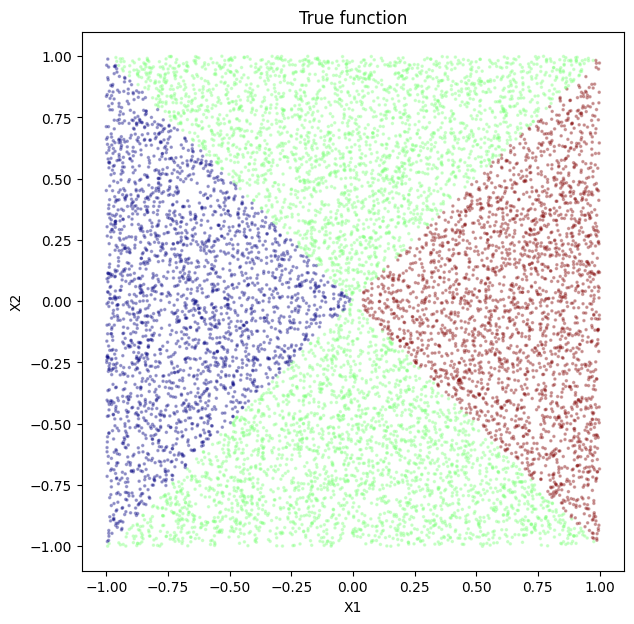

In [24]:
n = 10000
np.random.seed(265)

X = np.random.uniform(low=-1, high=1, size=2*n).reshape(n,2)
f = np.sign(X[:,0] - X[:,1]) + np.sign(X[:,0] + X[:,1])
y = f + np.random.normal(size=n)

fig = plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=f, alpha=.3, s=2.5, cmap='jet')
plt.xlabel('X1')
plt.ylabel('X2')
_ = plt.title('True function')

### 3.1 Build regressions trees with different depth

In this problem you are asked to build a sequence of regression trees using this data, to predict `y` from `x1` and `x2`, varying the tree depth.

* Vary the maximuim tree depth from 1 to 7
* Train each tree on a random set of 500 data points
* Test on the remaining 10000 - 500 data points
* Run 500 trials (train/test splits) for each depth.
* Plot the MSE as a function of the maximum tree depth

The cell below contains some starter code. You may modify this starter code in any way you wish. But be sure to *keep the lines at the end, which plots the mean squared error on the test data versus the depth.*

100%|██████████| 7/7 [00:15<00:00,  2.20s/it]

[2.01213858 1.79498291 1.70111771 1.57783428 1.58582489 1.69000181
 1.80415723]


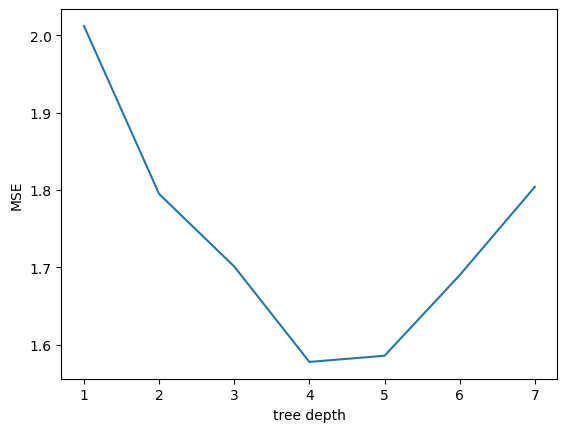

In [27]:
trials = 500
tree_depth = np.arange(1, 8)
test_mean_squared_error = np.zeros(len(tree_depth))

from tqdm import tqdm
for d in tqdm(tree_depth):
    rtree = DecisionTreeRegressor(max_depth=d)
    mse_list = []
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 500)
        model = rtree.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        mse = np.mean((y_test - y_predict) ** 2)
        mse_list.append(mse)
    test_mean_squared_error[d-1] = np.mean(mse_list)

fig = plt.figure()
plt.plot(tree_depth, test_mean_squared_error)
plt.xlabel('tree depth')
plt.ylabel('MSE')
print(test_mean_squared_error)

### 3.2 What is the best size of tree?

(a) According to your plot above, what is the best tree depth to choose?

(b) If the regression trees were trained on 5000 data points, rather than 500, how would the choice of tree depth change? Would it increase or decrease? Explain why. Try to answer this question without running any code! If you run an experiment, comment on this in your answer.


Answer:

(a). The best tree depth is 4, which corresponds to the lowest MSE.

(b). With more training data, there will be more data per leaf, and the variance will decrease. Therefore, it's affordable for a more complex model (deeper tree) without exploding variance. So the choice of tree depth will likely increase.


### 3.3 Estimate the squared bias and variance
Now estimate the squared bias and variance of the trees as a function of the maximum depth. This is possible in this case because you know the true function `f`, which was defined above. Use the same setup as above:

* Vary the maximuim tree depth from 1 to 7
* Train each tree on a random set of 500 data points
* Run 500 trials for each train/test split.

To estimate the squared bias and variance, evaluate each of the models on each of the $n=10,000$ data points. You can then estimate the squared bias and variance of the predictions $\hat y_i = \hat f(x_i)$ and take the average
over all the data points.

Hint: Consider using the fact that the variance of a random variable can be written as $\mbox{Var}(Z) = \mathbb{E}(Z^2) - \mathbb{E}(Z)^2$.  The cell below contains starter code based on this hint. You will need to use the true regression function `f` defined above as a numpy array.

You may modify this starter code in any way you wish. But be sure to *keep the lines at the end, which plots the squared bias and variance.*

100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


[np.float64(0.8655108175098978), np.float64(0.6453386780095881), np.float64(0.42199375656991517), np.float64(0.24262626474765545), np.float64(0.1792392050996432), np.float64(0.14840841585403206), np.float64(0.12917345743932104)]
[np.float64(0.16667355112124027), np.float64(0.16081502961106584), np.float64(0.27878851013164874), np.float64(0.3273402501563028), np.float64(0.3977237251070635), np.float64(0.5302078241412909), np.float64(0.6668542570617214)]


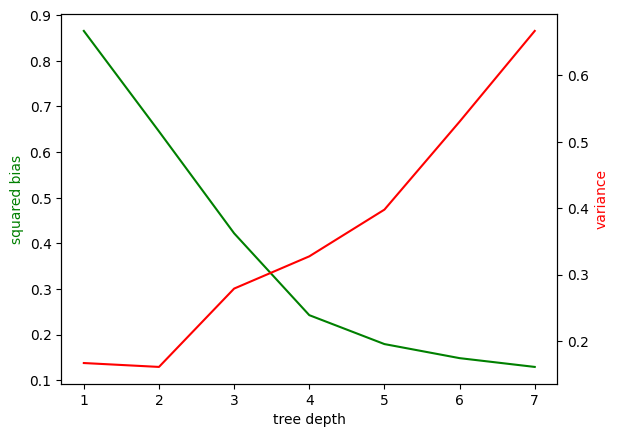

In [30]:
trials = 500
tree_depth = np.arange(1, 8)
bias_squared = []
variance = []

from tqdm import tqdm
for d in tqdm(tree_depth):
    rtree = DecisionTreeRegressor(max_depth=d)
    E_yhat = np.zeros(n)
    E_yhat_squared = np.zeros(n)
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 500)
        model = rtree.fit(X_train, y_train)
        y_predict = model.predict(X)
        E_yhat += y_predict
        E_yhat_squared += y_predict ** 2
    E_yhat = E_yhat / trials
    E_yhat_squared = E_yhat_squared / trials

    # just run the following lines (or modify as needed)
    bias_squared.append(np.mean((E_yhat - f)**2))
    variance.append(np.mean(E_yhat_squared - E_yhat**2))


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(tree_depth, bias_squared, 'g-')
ax2.plot(tree_depth, variance, 'r-')
ax1.set_xlabel('tree depth')
ax1.set_ylabel('squared bias', color='g')
_ = ax2.set_ylabel('variance', color='r')
print(bias_squared)
print(variance)

### 3.4 Do the bias and variance make sense?

(a) Explain why your plots of the squared bias and variance make sense, and are consistent with your plot of the MSE computed previously.

(b) What is the (approximate) value of the difference between the MSE and the sum of the squared bias and variance for this data set?


Answer:

(a). Squared bias decreases as depth increases, indicating deeper trees can fit more complex patterns, so they're less biased. Variance increases as depth increases, indicating deeper trees have more parameters, creating smaller leaf regions with fewer training samples. The MSE plot showed a curve with minimum around depth 4. This matches the bias-variance plot because at depth 4, bias and variance are balanced, which is a feature corresponding to lowest MSE. Besides, from squared bias-variance plot, we observe that the lower the tree depth, the higher the bias dominates and the lower the variance.

(b). Reading from the plots, mase at depth = 4 is approximately 1.58, the squared bias at depth = 4 is approximately 0.24, and the variance at the same place is roughly 0.33. The difference is MSE - Bias$^2$ - Variance $\approx$ 1.58 - 0.24 - 0.33 = 1.01. According to
MSE = Bias$^2$ + Variance + $\sigma^2$, the difference is the irreducible error term and should be constant across all depths.